## 7. epoch调参分析

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

Global seed set to 0
/home/21031211625/anaconda3/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/21031211625/anaconda3/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

1. 读取数据

In [3]:
# # 红系成熟部分
# # adata_filename = "./data/erythroid_lineage.h5ad"
# # adata_filename = "/home/huang/PyCode/scRNA/data/Gastrulation/erythroid_lineage.h5ad" # 实验室服务器的数据路径
# adata_filename = "/home/21031211625/Code/rna_velocity_expirement/data/Gastrulation/erythroid_lineage.h5ad" # 集群服务器的数据路径


# adata = scv.read(adata_filename)
# batch_key = "stage"
# cluster_key = "celltype"
# adata

## 预处理

In [4]:
# batch_pair_list = [
#     ["E7.0", "E7.25"],
#     ["E7.25", "E7.5"],
#     ["E7.5", "E7.75"],
#     ["E7.75", "E8.0"],
#     ["E8.0", "E8.25"],
#     ["E8.25", "E8.5"],
# ]
# knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)
# 这里同一读取之前速率估计时保存的对象
adata = velovgi.tl.read_adata("./data/adata/")
subsample_adata = scv.read("./data/subsample_adata.h5ad")
adata, subsample_adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


(AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
     obsm: 'X_pca', 'X_umap', 'velocity_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 4907 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 

## 断点训练

In [5]:
model_epoch_sep_savedir = "./model/epoch_parameter_adjustment" # TODO: 这里保存路径以后需要更改
log_epoch_sep_save_dir = "./log/epoch_parameter_adjustment"

# TODO: 集群跑的调大一点
# max_epochs = 10 
# sep = 5
max_epochs = 500 
sep = 50
epoch_list = range(0, max_epochs+1, sep)[1:] # TOOD: 数据量越大，查看的epoch间隔应该越小


# 每次断点指定模型训练的epoch
sep_epoch_list = [epoch_list[0]] 
for i in range(1, len(epoch_list)):
    sep_epoch_list.append(epoch_list[i]-epoch_list[i-1])
# sep_epoch_list.append(max_epochs-epoch_list[-1]) # 最后这个不保存
sep_epoch_list

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [6]:
from pytorch_lightning import loggers

velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    sep_epoch = sep_epoch_list[i] # 此次断点训练的epoch数目
    print(epoch, sep_epoch)
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    logger = loggers.TensorBoardLogger(save_dir=log_epoch_sep_save_dir, name=name) # 构造日志文件
    
    velovgi_model.train(max_epochs=sep_epoch, logger=logger, checkpoint_mode="checkpoint")
    velovgi_model.save("%s/%s"%(model_epoch_sep_savedir, name))# 模型保存

50 50
初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/50_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s, loss=4.44e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s, loss=4.44e+05, v_num=0]
100 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/100_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:26<00:00,  1.97it/s, loss=2.93e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s, loss=2.93e+05, v_num=0]
150 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/150_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:28<00:00,  1.66it/s, loss=1.83e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s, loss=1.83e+05, v_num=0]
200 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/200_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:29<00:00,  1.86it/s, loss=1.16e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:29<00:00,  1.68it/s, loss=1.16e+05, v_num=0]
250 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/250_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.75it/s, loss=6.91e+04, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s, loss=6.91e+04, v_num=0]
300 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/300_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:26<00:00,  1.91it/s, loss=3.81e+04, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s, loss=3.81e+04, v_num=0]
350 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/350_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.96it/s, loss=1.89e+04, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s, loss=1.89e+04, v_num=0]
400 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/400_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.91it/s, loss=1.63e+04, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s, loss=1.63e+04, v_num=0]
450 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/450_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:28<00:00,  1.71it/s, loss=1.56e+04, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s, loss=1.56e+04, v_num=0]
500 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/500_epoch(max_epochs=500)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.95it/s, loss=1.49e+04, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s, loss=1.49e+04, v_num=0]


## 读取断点训练结果，看看整体和基因速率图

1. 读取断点训练结果

In [7]:
name_list =[]
adata_list = []

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    name_list.append(name)
    # 提取模型
    # model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=True) # 服务器任务使用gpu
    model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=False) # 服务器、集群登录结点使用cpu，
     # 输出结果
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, model)
    tmp_adata = adata.copy()
    velovgi.pp.moment_recover(tmp_adata, subsample_adata)
    adata_list.append(tmp_adata)
adata_list

INFO     File ./model/epoch_parameter_adjustment/50_epoch(max_epochs=500)/model.pt already downloaded              
INFO     File ./model/epoch_parameter_adjustment/100_epoch(max_epochs=500)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/150_epoch(max_epochs=500)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/200_epoch(max_epochs=500)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/250_epoch(max_epochs=500)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/300_epoch(max_epochs=500)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/350_epoch(max_epochs=500)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/400_epoch(max_epochs=500)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/450_epoch(max_epochs=50

[AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
     obsm: 'X_pca', 'X_umap', 'velocity_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
     var: 'Accession', 'Chromosome', 'End', 'Start', 

2. 绘制整体速率图

绘制整体速率图
50_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
100_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 9 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
150_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 9 regions of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
200_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 6 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
250_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 8 regions of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
300_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
350_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 7 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
400_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:37) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
450_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 9 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
500_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:38) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 8 regions of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


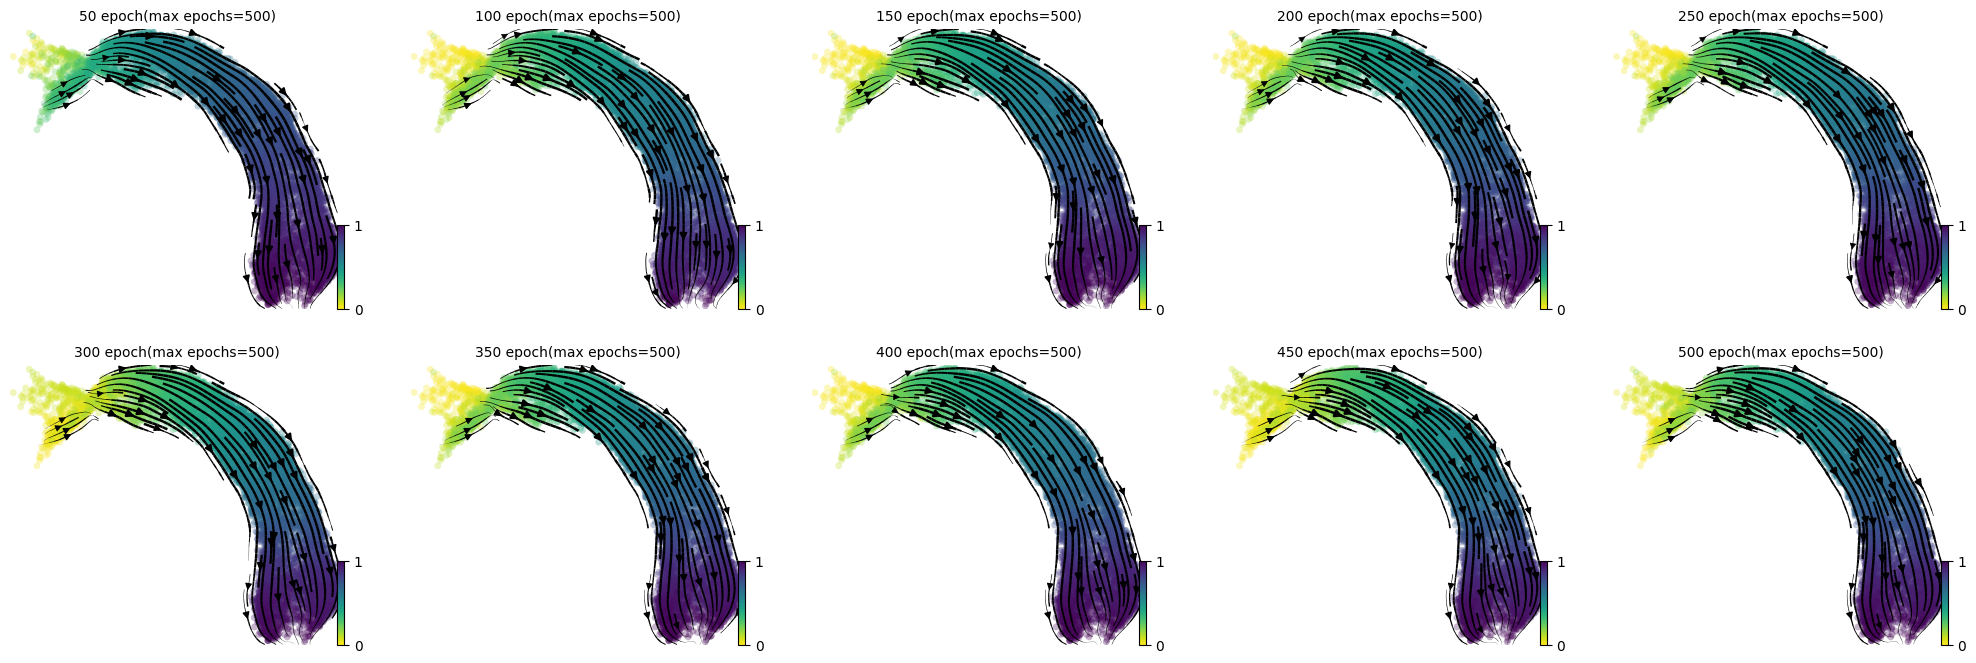

In [8]:
print("绘制整体速率图")
n = len(epoch_list)
fig, ax = velovgi.pl.calc_fig(n)
for i in range(n):
    print(name_list[i])
    name = name_list[i]
    tmp_adata = adata_list[i]
    scv.tl.velocity_graph(tmp_adata) # 转移矩阵计算
    scv.tl.velocity_pseudotime(tmp_adata) # 速率的伪时间计算
    scv.pl.velocity_embedding_stream(tmp_adata, color="velocity_pseudotime", ax=ax[i], title=name, show=False)

## 调参选择